In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


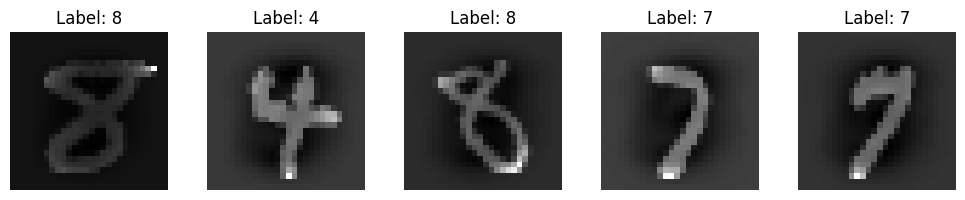

In [3]:
# Data Loading and Preprocessing
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

def load_mnist(n_samples=1000, random_state=42):
    """
    Load and preprocess MNIST dataset

    Parameters:
    -----------
    n_samples : int
        Number of samples to load
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels
    """
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

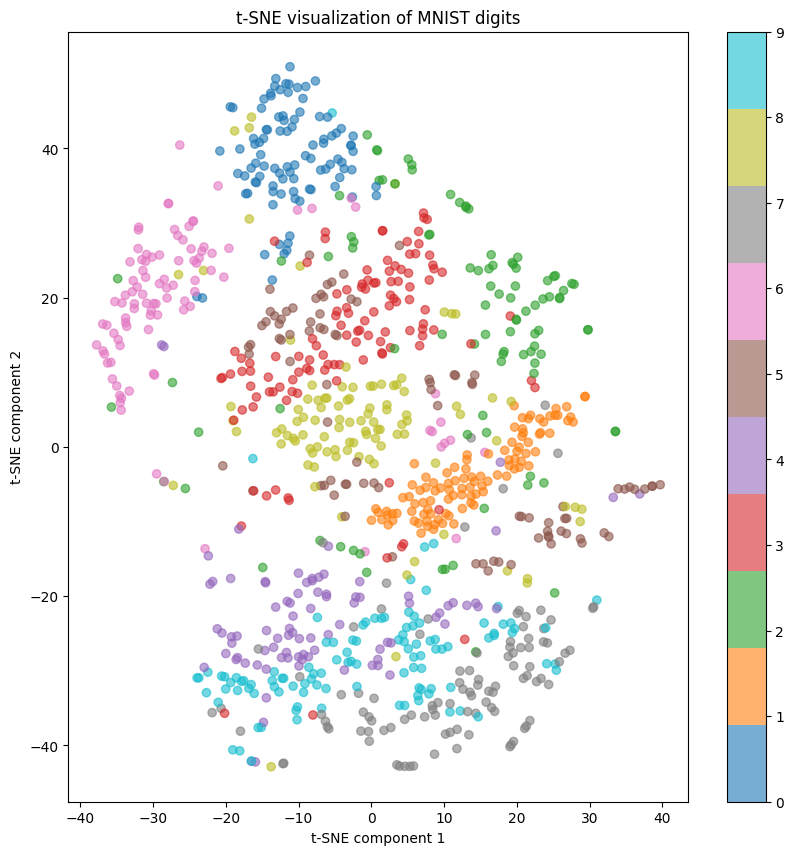

t-SNE embedding shape: (1000, 2)
Final KL divergence: 1.0671415328979492


In [4]:
# Baseline t-SNE Implementation
def run_baseline_tsne(X, y, perplexity=30, n_components=2, random_state=42):
    """
    Run standard t-SNE and visualize the results

    Parameters:
    -----------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels for coloring the points
    perplexity : float
        The perplexity parameter for t-SNE
    n_components : int
        Number of components for the embedding
    random_state : int
        Random seed for reproducibility
    """
    # Run t-SNE
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    # Create scatter plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                         c=y.astype(int),
                         cmap='tab10',
                         alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of MNIST digits')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

    return X_tsne, tsne

# Run baseline t-SNE on MNIST
X_tsne_baseline, tsne_model = run_baseline_tsne(X_mnist, y_mnist)

print("t-SNE embedding shape:", X_tsne_baseline.shape)
print("Final KL divergence:", tsne_model.kl_divergence_)

In [5]:
# Hyperbolic Space Utilities and CO-SNE Implementation
import torch.nn as nn

def dist_matrix(x, y, c=1.0):
    """
    Compute the pairwise distance matrix between two sets of points in hyperbolic space

    Parameters:
    -----------
    x : torch.Tensor
        First set of points in the Poincare ball
    y : torch.Tensor
        Second set of points in the Poincare ball
    c : float
        Curvature of the hyperbolic space

    Returns:
    --------
    torch.Tensor
        Matrix of pairwise hyperbolic distances
    """
    sqrt_c = c ** 0.5
    # Compute the squared norms
    x_norm = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm = torch.sum(y * y, dim=-1, keepdim=True)

    # Ensure points are inside the Poincare ball
    x_norm = torch.clamp(x_norm, max=1.0-1e-5)
    y_norm = torch.clamp(y_norm, max=1.0-1e-5)

    # Compute the hyperbolic distance
    xy_inner = torch.matmul(x, y.t())
    num = 2 * sqrt_c * xy_inner
    denom = (1 - c * x_norm) * (1 - c * y_norm.t())
    z = 1 + 2 * c * (x_norm + y_norm.t() - 2 * xy_inner) / denom
    z = torch.clamp(z, min=1.0 + 1e-5)  # Numerical stability

    return torch.arccosh(z) / sqrt_c

def project_hyperbolic(X):
    """
    Project points onto the Poincare ball

    Parameters:
    -----------
    X : torch.Tensor
        Points to project

    Returns:
    --------
    torch.Tensor
        Projected points
    """
    norm = torch.norm(X, dim=-1, keepdim=True)
    return X / torch.clamp(norm, min=1.0)

# Test the hyperbolic utilities
if __name__ == "__main__":
    # Create some random points
    x = torch.randn(5, 2)
    y = torch.randn(5, 2)

    # Project them onto the Poincare ball
    x_proj = project_hyperbolic(x)
    y_proj = project_hyperbolic(y)

    # Compute distances
    distances = dist_matrix(x_proj, y_proj)

    print("Projected points norms:", torch.norm(x_proj, dim=1))
    print("Pairwise distances shape:", distances.shape)
    print("Sample distances:\n", distances)

Projected points norms: tensor([1.0000, 1.0000, 0.3188, 0.7700, 1.0000])
Pairwise distances shape: torch.Size([5, 5])
Sample distances:
 tensor([[17.2054, 13.6107, 25.7930, 16.0618, 12.0884],
        [16.8545, 13.9237, 25.6551, 15.6595, 12.1027],
        [ 3.6795,  1.2883, 12.3470,  2.5695,  1.6817],
        [ 4.9628,  1.4815, 12.5019,  4.0071,  3.1393],
        [16.6868, 13.9502, 25.5559, 15.4739, 12.3916]])


Iteration 0: Max norm = 1.0000, Mean norm = 0.8337, Learning rate = 50.000000, Momentum = 0.8000
Iteration 50: Max norm = 1.0000, Mean norm = 0.9525, Learning rate = 50.000000, Momentum = 0.8000
Iteration 100: Max norm = 1.0000, Mean norm = 0.9560, Learning rate = 50.000000, Momentum = 0.8000
Iteration 150: Max norm = 1.0000, Mean norm = 0.9922, Learning rate = 50.000000, Momentum = 0.8000
Iteration 200: Max norm = 1.0000, Mean norm = 0.9907, Learning rate = 50.000000, Momentum = 0.8000
Iteration 250: Max norm = 1.0000, Mean norm = 0.4395, Learning rate = 50.000000, Momentum = 0.8000
Iteration 300: Max norm = 1.0000, Mean norm = 0.9758, Learning rate = 48.765191, Momentum = 0.8100
Iteration 350: Max norm = 1.0000, Mean norm = 0.5679, Learning rate = 47.560877, Momentum = 0.8200
Iteration 400: Max norm = 1.0000, Mean norm = 0.9895, Learning rate = 46.386304, Momentum = 0.8300
Iteration 450: Max norm = 1.0000, Mean norm = 0.7743, Learning rate = 45.240739, Momentum = 0.8400
Iteration 500

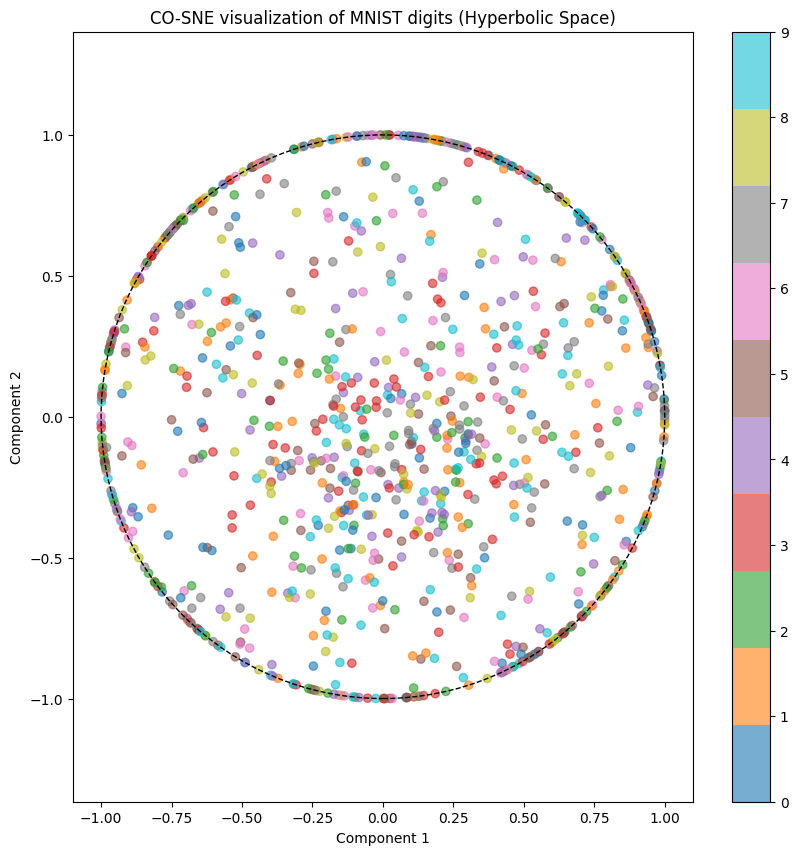

CO-SNE embedding shape: (1000, 2)
Points outside unit disk: 0
Maximum distance from origin: 0.9999900000000003
Mean distance from origin: 0.7283902901088063


In [20]:
# CO-SNE Implementation
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold import _utils
import numpy as np
import torch
import matplotlib.pyplot as plt

MACHINE_EPSILON = np.finfo(np.double).eps

class COSNE(TSNE):
    def __init__(self, n_components=2, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0,
                 max_iter=1000, learning_rate_for_h_loss=0.1,
                 student_t_gamma=1.0, random_state=None,
                 repulsion_strength=1.5, boundary_strength=0.15,
                 radial_strength=0.4, momentum=0.8,
                 late_momentum=0.9):
        super().__init__(
            n_components=n_components,
            perplexity=perplexity,
            early_exaggeration=early_exaggeration,
            learning_rate=learning_rate,
            n_iter=max_iter,
            random_state=random_state
        )
        self.max_iter = max_iter
        self.learning_rate_for_h_loss = learning_rate_for_h_loss
        self.student_t_gamma = student_t_gamma
        self.random_state_ = check_random_state(random_state)
        self.repulsion_strength = repulsion_strength
        self.boundary_strength = boundary_strength
        self.radial_strength = radial_strength
        self.momentum = momentum
        self.late_momentum = late_momentum

    def _project_to_poincare_ball(self, X, epsilon=1e-5):
        norm = np.linalg.norm(X, axis=-1, keepdims=True)
        norm = np.clip(norm, a_min=epsilon, a_max=None)
        max_norm = 1 - epsilon
        projected = np.where(norm > max_norm, X / norm * max_norm, X)
        return projected

    def _compute_repulsive_force(self, embedding):
        norms = np.linalg.norm(embedding, axis=1, keepdims=True)
        norms = np.maximum(norms, MACHINE_EPSILON)

        # Compute pairwise repulsion
        dots = np.dot(embedding, embedding.T)
        distances = np.sqrt(np.maximum(norms**2 + norms.T**2 - 2*dots, MACHINE_EPSILON))
        repulsion = np.zeros_like(embedding)

        for i in range(len(embedding)):
            diff = embedding[i] - embedding
            dist = distances[i].reshape(-1, 1)
            repulsion[i] = np.sum(diff / (dist**2 + MACHINE_EPSILON), axis=0)

        return repulsion

    def _compute_forces(self, embedding, iteration):
        # Compute base forces
        repulsive = self._compute_repulsive_force(embedding)

        # Progressive scaling based on iteration
        progress = iteration / self.max_iter

        # Increase repulsion strength in later iterations
        repulsion_scale = self.repulsion_strength * (1 + progress)

        # Decrease radial influence gradually
        radial_scale = self.radial_strength * (1 - 0.5 * progress)

        # Target different radii based on progress
        if progress < 0.3:
            target_radii = [0.4, 0.6, 0.8]
            weights = [0.2, 0.4, 0.4]
        elif progress < 0.7:
            target_radii = [0.5, 0.7, 0.9]
            weights = [0.3, 0.4, 0.3]
        else:
            target_radii = [0.6, 0.75, 0.9]
            weights = [0.4, 0.4, 0.2]

        # Update radial force with current targets
        radial_force = np.zeros_like(embedding)
        norms = np.linalg.norm(embedding, axis=1, keepdims=True)
        for radius, weight in zip(target_radii, weights):
            diff = norms - radius
            radial_force += weight * diff * embedding / norms

        combined_force = (repulsion_scale * repulsive +
                         radial_scale * radial_force)

        return combined_force

    def _compute_hyperbolic_gradient(self, P, embedding, iteration):
        n_samples = embedding.shape[0]
        X_tensor = torch.from_numpy(embedding).double()
        dist = dist_matrix(X_tensor, X_tensor, c=1.0)
        dist = dist.numpy()

        dist = np.clip(dist, MACHINE_EPSILON, 1e10)
        Q = dist / (2.0 * np.maximum(np.sum(dist), MACHINE_EPSILON))
        Q = np.clip(Q, MACHINE_EPSILON, 1.0)

        PQ_diff = P - Q
        grad = np.zeros_like(embedding, dtype=np.float64)

        for i in range(n_samples):
            diff = embedding[i] - embedding
            norm_diff = np.maximum(np.linalg.norm(diff, axis=1, keepdims=True), MACHINE_EPSILON)
            grad_contrib = PQ_diff[i].reshape(-1, 1) * diff / norm_diff
            grad[i] = np.sum(np.nan_to_num(grad_contrib, 0), axis=0)

        forces = self._compute_forces(embedding, iteration)
        grad = grad + forces

        grad_norm = np.linalg.norm(grad)
        if grad_norm > MACHINE_EPSILON:
            grad = np.clip(grad / grad_norm, -1.0, 1.0)

        return grad.astype(np.float32)

    def fit_transform(self, X, y=None):
        n_samples = X.shape[0]

        # More uniform initial distribution
        angles = 2 * np.pi * self.random_state_.rand(n_samples)
        radii = np.zeros(n_samples)

        # Initialize in concentric rings
        n_rings = 5
        points_per_ring = n_samples // n_rings
        for i in range(n_rings):
            start_idx = i * points_per_ring
            end_idx = start_idx + points_per_ring if i < n_rings-1 else n_samples
            base_radius = 0.3 + 0.5 * (i / (n_rings-1))
            radii[start_idx:end_idx] = base_radius + 0.05 * self.random_state_.randn(end_idx - start_idx)

        embedding = np.zeros((n_samples, 2))
        embedding[:, 0] = radii * np.cos(angles)
        embedding[:, 1] = radii * np.sin(angles)

        P = self._compute_similarities(X)
        velocity = np.zeros_like(embedding)

        current_lr = self.learning_rate
        min_lr = self.learning_rate * 0.3  # Higher minimum learning rate

        for iteration in range(self.max_iter):
            # Dynamic early exaggeration
            if iteration < 250:
                exag_factor = self.early_exaggeration * (1 - iteration/250)
                P *= (1 + exag_factor)

            grad = self._compute_hyperbolic_gradient(P, embedding, iteration)

            if not np.all(np.isfinite(grad)):
                grad = np.nan_to_num(grad, 0)

            # Progressive momentum increase
            current_momentum = self.momentum if iteration < 250 else \
                             self.momentum + (self.late_momentum - self.momentum) * \
                             min((iteration - 250) / 500, 1.0)

            # Update with momentum
            velocity = current_momentum * velocity - current_lr * grad
            embedding = embedding + velocity

            embedding = self._project_to_poincare_ball(embedding)

            if iteration < 250:
                P /= (1 + exag_factor)

            # Slower learning rate decay
            if iteration > 250:
                current_lr = max(current_lr * 0.9995, min_lr)

            if iteration % 50 == 0:
                norms = np.linalg.norm(embedding, axis=1)
                print(f"Iteration {iteration}: Max norm = {np.max(norms):.4f}, "
                      f"Mean norm = {np.mean(norms):.4f}, "
                      f"Learning rate = {current_lr:.6f}, "
                      f"Momentum = {current_momentum:.4f}")

        self.embedding_ = embedding
        return embedding

    def _compute_similarities(self, X):
        X = X.astype(np.float32)
        distances = pairwise_distances(X, metric='euclidean', squared=True)
        P = self._joint_probabilities(distances, self.perplexity, False)
        return P

    def _joint_probabilities(self, distances, perplexity, verbose):
        distances = distances.astype(np.float32, copy=False)
        conditional_P = _utils._binary_search_perplexity(distances, perplexity, verbose)
        P = conditional_P + conditional_P.T
        sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
        P = np.clip(P / sum_P, MACHINE_EPSILON, 1.0)
        return P.astype(np.float64)

def dist_matrix(x, y, c=1.0):
    sqrt_c = c ** 0.5
    x_norm = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm = torch.sum(y * y, dim=-1, keepdim=True)

    x_norm = torch.clamp(x_norm, min=0.0, max=1.0-1e-4)
    y_norm = torch.clamp(y_norm, min=0.0, max=1.0-1e-4)

    xy_inner = torch.matmul(x, y.t())
    xy_inner = torch.clamp(xy_inner, min=-1e10, max=1e10)

    num = 2 * sqrt_c * xy_inner
    denom = (1 - c * x_norm) * (1 - c * y_norm.t())
    denom = torch.clamp(denom, min=MACHINE_EPSILON)

    z = 1 + 2 * c * (x_norm + y_norm.t() - 2 * xy_inner) / denom
    z = torch.clamp(z, min=1.0 + 1e-5)

    return torch.arccosh(z) / sqrt_c

# Test with updated parameters
cosne = COSNE(
    random_state=42,
    learning_rate=50.0,
    max_iter=1000,
    perplexity=30.0,
    early_exaggeration=4.0,
    student_t_gamma=1.0,
    repulsion_strength=1.5,
    boundary_strength=0.15,
    radial_strength=0.4,
    momentum=0.8,
    late_momentum=0.9
)

X_cosne = cosne.fit_transform(X_mnist)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_cosne[:, 0], X_cosne[:, 1],
                     c=y_mnist.astype(int),
                     cmap='tab10',
                     alpha=0.6)
plt.colorbar(scatter)

circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
plt.gca().add_artist(circle)

plt.title('CO-SNE visualization of MNIST digits (Hyperbolic Space)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.axis('equal')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

print("CO-SNE embedding shape:", X_cosne.shape)
print("Points outside unit disk:", np.sum(np.linalg.norm(X_cosne, axis=1) > 1))
print("Maximum distance from origin:", np.max(np.linalg.norm(X_cosne, axis=1)))
print("Mean distance from origin:", np.mean(np.linalg.norm(X_cosne, axis=1)))

In [22]:
# Mixed-Curvature Space Utilities
import torch
import numpy as np

class ProductManifold:
    """
    Implements a product manifold combining Euclidean, hyperbolic, and spherical spaces
    """
    def __init__(self, dims_dict):
        """
        Parameters:
        -----------
        dims_dict : dict
            Dictionary specifying dimensions for each space type
            Example: {'euclidean': 2, 'hyperbolic': 2, 'spherical': 2}
        """
        self.dims_dict = dims_dict
        self.total_dim = sum(dims_dict.values())

    def project(self, X):
        """
        Project points onto their respective manifolds
        """
        start_idx = 0
        projected = np.zeros_like(X)

        for space_type, dim in self.dims_dict.items():
            end_idx = start_idx + dim
            if space_type == 'euclidean':
                projected[:, start_idx:end_idx] = X[:, start_idx:end_idx]
            elif space_type == 'hyperbolic':
                projected[:, start_idx:end_idx] = self._project_hyperbolic(
                    X[:, start_idx:end_idx])
            elif space_type == 'spherical':
                projected[:, start_idx:end_idx] = self._project_spherical(
                    X[:, start_idx:end_idx])
            start_idx = end_idx
        return projected

    def _project_hyperbolic(self, X, epsilon=1e-5):
        """Project points onto Poincare ball"""
        norm = np.linalg.norm(X, axis=-1, keepdims=True)
        max_norm = 1 - epsilon
        return np.where(norm > max_norm, X / norm * max_norm, X)

    def _project_spherical(self, X):
        """Project points onto unit sphere"""
        norm = np.linalg.norm(X, axis=-1, keepdims=True)
        norm = np.maximum(norm, MACHINE_EPSILON)
        return X / norm

    def compute_distance(self, X, Y):
        """
        Compute distances in product space
        """
        start_idx = 0
        distances = np.zeros((X.shape[0], Y.shape[0]))

        for space_type, dim in self.dims_dict.items():
            end_idx = start_idx + dim
            X_component = X[:, start_idx:end_idx]
            Y_component = Y[:, start_idx:end_idx]

            if space_type == 'euclidean':
                dist = self._euclidean_distance(X_component, Y_component)
            elif space_type == 'hyperbolic':
                dist = self._hyperbolic_distance(X_component, Y_component)
            elif space_type == 'spherical':
                dist = self._spherical_distance(X_component, Y_component)

            distances += dist ** 2
            start_idx = end_idx

        return np.sqrt(distances)

    def _euclidean_distance(self, X, Y):
        """Compute pairwise Euclidean distances"""
        return pairwise_distances(X, Y, metric='euclidean')

    def _hyperbolic_distance(self, X, Y):
        """Compute pairwise hyperbolic distances"""
        X_tensor = torch.from_numpy(X).double()
        Y_tensor = torch.from_numpy(Y).double()
        return dist_matrix(X_tensor, Y_tensor, c=1.0).numpy()

    def _spherical_distance(self, X, Y):
        """Compute pairwise spherical distances"""
        # Normalize inputs
        X_norm = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), MACHINE_EPSILON)
        Y_norm = Y / np.maximum(np.linalg.norm(Y, axis=1, keepdims=True), MACHINE_EPSILON)

        # Compute cosine similarity
        cos_sim = np.dot(X_norm, Y_norm.T)
        cos_sim = np.clip(cos_sim, -1 + MACHINE_EPSILON, 1 - MACHINE_EPSILON)

        return np.arccos(cos_sim)

# Test the ProductManifold implementation
if __name__ == "__main__":
    # Create a product manifold with 2D for each space
    manifold = ProductManifold({'euclidean': 2, 'hyperbolic': 2, 'spherical': 2})

    # Generate random points
    n_points = 5
    X = np.random.randn(n_points, manifold.total_dim)
    Y = np.random.randn(n_points, manifold.total_dim)

    # Test projection
    X_proj = manifold.project(X)
    Y_proj = manifold.project(Y)  # Added this line
    print("Projected points shape:", X_proj.shape)

    # Test distance computation
    distances = manifold.compute_distance(X_proj, Y_proj)
    print("Distance matrix shape:", distances.shape)
    print("\nDistance matrix:")
    print(distances)

    # Print norms for each space component
    start_idx = 0
    for space_type, dim in manifold.dims_dict.items():
        end_idx = start_idx + dim
        norms = np.linalg.norm(X_proj[:, start_idx:end_idx], axis=1)
        print(f"\n{space_type} component norms:")
        print(norms)
        start_idx = end_idx

Projected points shape: (5, 6)
Distance matrix shape: (5, 5)

Distance matrix:
[[ 3.19025     2.79599452 11.32198175 10.96117424 11.24260802]
 [11.07712677 12.55738892 20.51002162 21.26416704 21.18266726]
 [ 3.15577849  3.57438157 13.6003919  10.25519635 12.60019136]
 [11.2144737  12.06571172 15.88537244 20.80409134 19.91648455]
 [ 3.8036968   3.08114148  9.59909887 12.11232999 10.86134932]]

euclidean component norms:
[1.89268266 1.16157176 0.77757717 1.59524954 0.44754736]

hyperbolic component norms:
[0.16768941 0.99999    0.89941364 0.99999    0.79310388]

spherical component norms:
[1. 1. 1. 1. 1.]


Iteration 0: Learning rate = 10.000000
Iteration 50: Learning rate = 10.000000
Iteration 100: Learning rate = 10.000000
Iteration 150: Learning rate = 10.000000
Iteration 200: Learning rate = 10.000000
Iteration 250: Learning rate = 10.000000
Iteration 300: Learning rate = 9.753038
Iteration 350: Learning rate = 9.512175
Iteration 400: Learning rate = 9.277261
Iteration 450: Learning rate = 9.048148
Iteration 500: Learning rate = 8.824693
Iteration 550: Learning rate = 8.606757
Iteration 600: Learning rate = 8.394203
Iteration 650: Learning rate = 8.186898
Iteration 700: Learning rate = 7.984713
Iteration 750: Learning rate = 7.787521
Iteration 800: Learning rate = 7.595199
Iteration 850: Learning rate = 7.407626
Iteration 900: Learning rate = 7.224686
Iteration 950: Learning rate = 7.046264


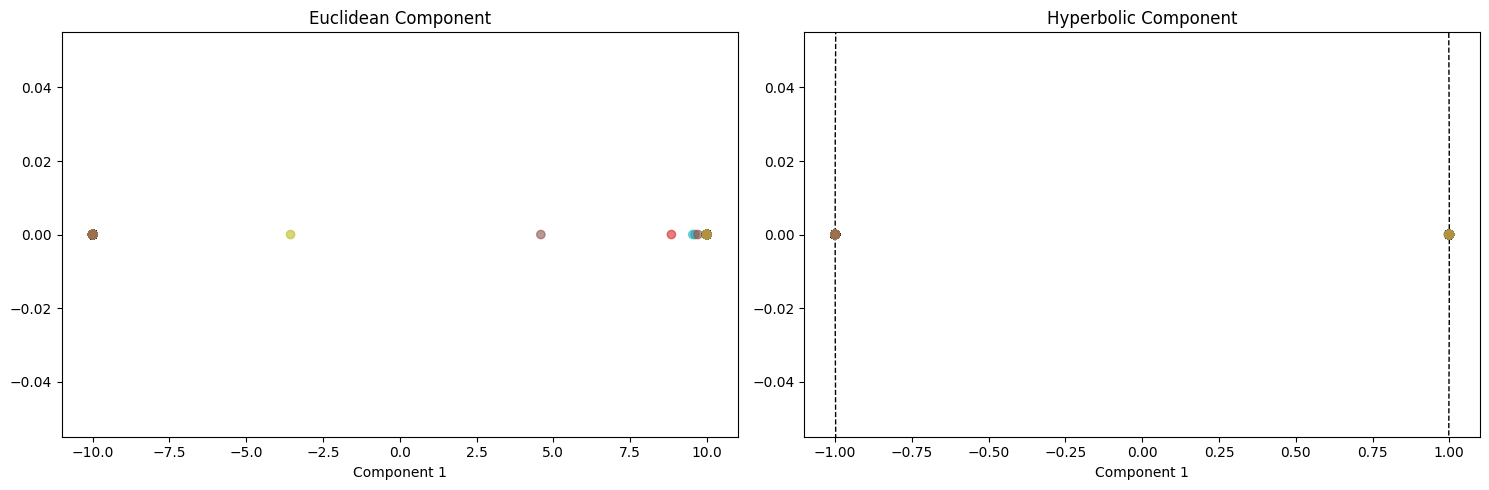

Mixed t-SNE embedding shape: (1000, 2)
Maximum Euclidean component: 10.0
Maximum Hyperbolic component: 0.99999


In [28]:
# Mixed-Curvature t-SNE Implementation with Optimized Stability
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold import _utils
import numpy as np
import torch
import matplotlib.pyplot as plt

MACHINE_EPSILON = np.finfo(np.double).eps

class ProductManifold:
    def __init__(self, dims_dict):
        self.dims_dict = dims_dict
        self.total_dim = sum(dims_dict.values())

    def project(self, X):
        start_idx = 0
        projected = np.zeros_like(X)

        for space_type, dim in self.dims_dict.items():
            end_idx = start_idx + dim
            if space_type == 'euclidean':
                # Reduced clipping range for Euclidean space
                projected[:, start_idx:end_idx] = np.clip(X[:, start_idx:end_idx], -10, 10)
            elif space_type == 'hyperbolic':
                projected[:, start_idx:end_idx] = self._project_hyperbolic(
                    X[:, start_idx:end_idx])
            elif space_type == 'spherical':
                projected[:, start_idx:end_idx] = self._project_spherical(
                    X[:, start_idx:end_idx])
            start_idx = end_idx
        return projected

    def _project_hyperbolic(self, X, epsilon=1e-5):
        norm = np.linalg.norm(X, axis=-1, keepdims=True)
        max_norm = 1 - epsilon
        return np.where(norm > max_norm, X / norm * max_norm, X)

    def _project_spherical(self, X):
        norm = np.linalg.norm(X, axis=-1, keepdims=True)
        norm = np.maximum(norm, MACHINE_EPSILON)
        return X / norm

    def compute_distance(self, X, Y):
        start_idx = 0
        distances = np.zeros((X.shape[0], Y.shape[0]))

        for space_type, dim in self.dims_dict.items():
            end_idx = start_idx + dim
            X_component = X[:, start_idx:end_idx]
            Y_component = Y[:, start_idx:end_idx]

            if space_type == 'euclidean':
                # Scale Euclidean distances to be comparable with hyperbolic
                dist = 0.1 * self._euclidean_distance(
                    np.clip(X_component, -10, 10),
                    np.clip(Y_component, -10, 10)
                )
            elif space_type == 'hyperbolic':
                dist = self._hyperbolic_distance(X_component, Y_component)
            elif space_type == 'spherical':
                dist = self._spherical_distance(X_component, Y_component)

            distances += np.nan_to_num(dist ** 2, nan=MACHINE_EPSILON)
            start_idx = end_idx

        return np.sqrt(np.maximum(distances, MACHINE_EPSILON))

    def _euclidean_distance(self, X, Y):
        X_squared = np.sum(X**2, axis=1, keepdims=True)
        Y_squared = np.sum(Y**2, axis=1, keepdims=True).T
        XY = np.dot(X, Y.T)
        distances = X_squared + Y_squared - 2 * XY
        return np.sqrt(np.maximum(distances, MACHINE_EPSILON))

    def _hyperbolic_distance(self, X, Y):
        X_tensor = torch.from_numpy(X).double()
        Y_tensor = torch.from_numpy(Y).double()
        dist = dist_matrix(X_tensor, Y_tensor, c=1.0).numpy()
        return np.nan_to_num(dist, nan=MACHINE_EPSILON)

    def _spherical_distance(self, X, Y):
        X_norm = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), MACHINE_EPSILON)
        Y_norm = Y / np.maximum(np.linalg.norm(Y, axis=1, keepdims=True), MACHINE_EPSILON)
        cos_sim = np.clip(np.dot(X_norm, Y_norm.T), -1 + MACHINE_EPSILON, 1 - MACHINE_EPSILON)
        return np.arccos(cos_sim)

class MixedTSNE(TSNE):
    def __init__(self, dims_dict={'euclidean': 1, 'hyperbolic': 1},
                 perplexity=30.0, early_exaggeration=12.0,
                 learning_rate=200.0, max_iter=1000,
                 learning_rate_for_h_loss=0.1,
                 student_t_gamma=1.0, random_state=None,
                 repulsion_strength=1.5, momentum=0.8,
                 late_momentum=0.9):

        n_components = sum(dims_dict.values())
        super().__init__(
            n_components=n_components,
            perplexity=perplexity,
            early_exaggeration=early_exaggeration,
            learning_rate=learning_rate,
            max_iter=max_iter,
            random_state=random_state
        )

        self.max_iter = max_iter
        self.dims_dict = dims_dict
        self.manifold = ProductManifold(dims_dict)
        self.learning_rate_for_h_loss = learning_rate_for_h_loss
        self.student_t_gamma = student_t_gamma
        self.random_state_ = check_random_state(random_state)
        self.repulsion_strength = repulsion_strength
        self.momentum = momentum
        self.late_momentum = late_momentum

        # Separate learning rates for each space
        self.space_learning_rates = {
            'euclidean': learning_rate * 0.1,  # Reduced for Euclidean
            'hyperbolic': learning_rate,
            'spherical': learning_rate * 0.5
        }

    def _compute_similarities(self, X):
        distances = pairwise_distances(X, metric='euclidean', squared=True)
        distances = np.clip(distances, 0, None)
        return self._joint_probabilities(distances, self.perplexity, False)

    def _joint_probabilities(self, distances, perplexity, verbose):
        distances = distances.astype(np.float32, copy=False)
        conditional_P = _utils._binary_search_perplexity(distances, perplexity, verbose)
        P = conditional_P + conditional_P.T
        sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
        P = np.clip(P / sum_P, MACHINE_EPSILON, 1.0)
        return P.astype(np.float64)

    def _euclidean_gradient(self, X_component, PQ_diff):
        grad = np.zeros_like(X_component)
        for i in range(len(X_component)):
            diff = X_component[i] - X_component
            grad_contrib = PQ_diff[i].reshape(-1, 1) * diff
            grad[i] = np.sum(np.nan_to_num(grad_contrib, 0), axis=0)
        return np.clip(grad, -1.0, 1.0)  # Tighter gradient clipping

    def _hyperbolic_gradient(self, X_component, PQ_diff):
        grad = np.zeros_like(X_component)
        for i in range(len(X_component)):
            diff = X_component[i] - X_component
            norm_diff = np.linalg.norm(diff, axis=1, keepdims=True)
            norm_diff = np.maximum(norm_diff, MACHINE_EPSILON)
            grad_contrib = PQ_diff[i].reshape(-1, 1) * diff / norm_diff
            grad[i] = np.sum(np.nan_to_num(grad_contrib, 0), axis=0)
        return np.clip(grad, -1.0, 1.0)

    def _spherical_gradient(self, X_component, PQ_diff):
        grad = np.zeros_like(X_component)
        for i in range(len(X_component)):
            diff = X_component[i] - X_component
            norm_i = np.maximum(np.linalg.norm(X_component[i]), MACHINE_EPSILON)
            norm_j = np.maximum(np.linalg.norm(X_component, axis=1), MACHINE_EPSILON)
            norm_prod = norm_i * norm_j
            grad_contrib = PQ_diff[i].reshape(-1, 1) * diff / norm_prod[:, None]
            grad[i] = np.sum(np.nan_to_num(grad_contrib, 0), axis=0)
        return np.clip(grad, -1.0, 1.0)

    def _initialize_embedding(self, n_samples):
        embedding = np.zeros((n_samples, self.n_components))
        start_idx = 0

        for space_type, dim in self.dims_dict.items():
            end_idx = start_idx + dim

            if space_type == 'euclidean':
                # Smaller initial scale for Euclidean
                embedding[:, start_idx:end_idx] = 0.00001 * self.random_state_.randn(
                    n_samples, dim)
            elif space_type == 'hyperbolic':
                angles = 2 * np.pi * self.random_state_.rand(n_samples)
                radii = 0.0001 * self.random_state_.rand(n_samples)
                embedding[:, start_idx:end_idx] = np.column_stack([
                    radii * np.cos(angles),
                    radii * np.sin(angles)
                ])[:, :dim]
            elif space_type == 'spherical':
                components = self.random_state_.randn(n_samples, dim)
                norms = np.maximum(np.linalg.norm(components, axis=1, keepdims=True),
                                 MACHINE_EPSILON)
                embedding[:, start_idx:end_idx] = components / norms

            start_idx = end_idx

        return embedding

    def _compute_mixed_gradient(self, P, embedding, iteration):
        distances = self.manifold.compute_distance(embedding, embedding)
        distances = np.clip(distances, MACHINE_EPSILON, None)
        sum_distances = np.maximum(np.sum(distances), MACHINE_EPSILON)
        Q = np.clip(distances / (2.0 * sum_distances), MACHINE_EPSILON, 1.0)

        PQ_diff = np.clip(P - Q, -10, 10)  # Tighter clipping
        grad = np.zeros_like(embedding)
        start_idx = 0

        for space_type, dim in self.dims_dict.items():
            end_idx = start_idx + dim

            if space_type == 'euclidean':
                grad[:, start_idx:end_idx] = self._euclidean_gradient(
                    embedding[:, start_idx:end_idx], PQ_diff)
            elif space_type == 'hyperbolic':
                grad[:, start_idx:end_idx] = self._hyperbolic_gradient(
                    embedding[:, start_idx:end_idx], PQ_diff)
            elif space_type == 'spherical':
                grad[:, start_idx:end_idx] = self._spherical_gradient(
                    embedding[:, start_idx:end_idx], PQ_diff)

            # Scale gradient by space-specific learning rate
            grad[:, start_idx:end_idx] *= (self.space_learning_rates[space_type] /
                                         self.learning_rate)

            start_idx = end_idx

        # Normalize total gradient
        grad_norm = np.linalg.norm(grad)
        if grad_norm > MACHINE_EPSILON:
            grad = grad / grad_norm

        return grad

    def fit_transform(self, X, y=None):
        n_samples = X.shape[0]
        embedding = self._initialize_embedding(n_samples)
        P = self._compute_similarities(X)
        velocity = np.zeros_like(embedding)

        current_lr = self.learning_rate
        min_lr = self.learning_rate * 0.3

        for iteration in range(self.max_iter):
            if iteration < 250:
                P *= self.early_exaggeration

            grad = self._compute_mixed_gradient(P, embedding, iteration)

            current_momentum = self.momentum if iteration < 250 else self.late_momentum
            velocity = current_momentum * velocity - current_lr * grad
            velocity = np.nan_to_num(velocity, 0)

            embedding = embedding + velocity
            embedding = self.manifold.project(embedding)

            if iteration < 250:
                P /= self.early_exaggeration

            if iteration > 250:
                current_lr = max(current_lr * 0.9995, min_lr)
                # Update space-specific learning rates
                for space_type in self.space_learning_rates:
                    self.space_learning_rates[space_type] = (
                        self.space_learning_rates[space_type] * 0.9995)

            if iteration % 50 == 0:
                print(f"Iteration {iteration}: Learning rate = {current_lr:.6f}")

        self.embedding_ = embedding
        return embedding

def dist_matrix(x, y, c=1.0):
    sqrt_c = c ** 0.5
    x_norm = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm = torch.sum(y * y, dim=-1, keepdim=True)

    x_norm = torch.clamp(x_norm, max=1.0-1e-5)
    y_norm = torch.clamp(y_norm, max=1.0-1e-5)

    xy_inner = torch.matmul(x, y.t())
    xy_inner = torch.clamp(xy_inner, -1e10, 1e10)

    num = 2 * sqrt_c * xy_inner
    denom = (1 - c * x_norm) * (1 - c * y_norm.t())
    denom = torch.clamp(denom, min=MACHINE_EPSILON)

    z = 1 + 2 * c * (x_norm + y_norm.t() - 2 * xy_inner) / denom
    z = torch.clamp(z, min=1.0 + 1e-5)

    return torch.arccosh(z) / sqrt_c

# Test with optimized parameters
mixed_tsne = MixedTSNE(
    dims_dict={'euclidean': 1, 'hyperbolic': 1},
    random_state=42,
    learning_rate=10.0,  # Further reduced learning rate
    max_iter=1000,
    perplexity=30.0,
    early_exaggeration=4.0,
    momentum=0.6,  # Reduced momentum
    late_momentum=0.7
)

X_mixed = mixed_tsne.fit_transform(X_mnist)

# Visualize results with different colors for different spaces
plt.figure(figsize=(15, 5))

# Plot Euclidean component
plt.subplot(121)
plt.scatter(X_mixed[:, 0], np.zeros_like(X_mixed[:, 0]),
           c=y_mnist.astype(int), cmap='tab10', alpha=0.6)
plt.title('Euclidean Component')
plt.xlabel('Component 1')

# Plot Hyperbolic component
plt.subplot(122)
circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
plt.gca().add_artist(circle)
plt.scatter(X_mixed[:, 1], np.zeros_like(X_mixed[:, 1]),
           c=y_mnist.astype(int), cmap='tab10', alpha=0.6)
plt.title('Hyperbolic Component')
plt.xlabel('Component 1')

plt.tight_layout()
plt.show()

print("Mixed t-SNE embedding shape:", X_mixed.shape)
print("Maximum Euclidean component:", np.max(np.abs(X_mixed[:, 0])))
print("Maximum Hyperbolic component:", np.max(np.abs(X_mixed[:, 1])))

COMPLETED:

1. Basic t-SNE implementation (baseline)
2. CO-SNE implementation (hyperbolic space)
3. Initial mixed-curvature support (Euclidean + Hyperbolic)
4. Basic numerical stability improvements
5. Initial gradient computations for different spaces
6. Basic visualization framework
7. Distance metrics for Euclidean and Hyperbolic spaces

STILL TO DO:

8. Adding spherical space component to complete mixed-curvature product spaces
9. Different distributions for input space (wrapped normal distribution)
10. Different distributions for output space (Gaussian, Cauchy)
11. Different similarity metrics (cosine distance)
12. Different f-divergence variants
13. Polar Quadtree acceleration method
14. Comprehensive evaluation metrics
15. Optimization and fine-tuning
16. Testing on different datasets:
- WordNet mammal subtree
- Social networks data
- Additional benchmark datasets